In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Milestone stuff

In [ ]:
filepath = 'SPY.csv'
raw_df = pd.read_csv(filepath)

In [ ]:
raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,267.839996,268.809998,267.399994,268.769989,253.283142,86655700
1,2018-01-03,268.959991,270.640015,268.959991,270.470001,254.885162,90070400
2,2018-01-04,271.200012,272.160004,270.540009,271.609985,255.959488,80636400
3,2018-01-05,272.510010,273.559998,271.950012,273.420013,257.665283,83524000
4,2018-01-08,273.309998,274.100006,272.980011,273.920013,258.136414,57319200


In [ ]:
df = raw_df.copy()
columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for index in range(15):
  shift = index + 1
  for col in columns:
    col_name = 'Day - ' +str(shift) + ' ' + col
    series = raw_df[col].shift(periods=shift)
    df[col_name] = series

In [ ]:
df = df.drop(range(15)).drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
df = df.reset_index(drop=True)
min_max_scaler = MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df))
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,0.374605,0.362549,0.419541,0.404180,0.313716,0.206518,0.361600,0.356298,0.404751,0.400161,0.309984,0.191026,0.359026,0.340973,0.398456,0.384889,0.298772,0.324371,0.356800,0.337949,0.394790,0.376382,0.290794,0.216314,0.346713,0.338554,0.384253,0.379530,0.293746,0.250003,0.355896,0.338822,0.379082,0.361846,0.277163,0.231980,0.335513,0.339193,0.378428,0.368210,...,0.362924,0.347575,0.262859,0.132556,0.323849,0.322346,0.373478,0.350428,0.265534,0.099433,0.316210,0.314211,0.366118,0.346217,0.261585,0.099608,0.310603,0.310391,0.359227,0.342820,0.258401,0.170060,0.301423,0.300488,0.349793,0.330526,0.246873,0.162297,0.285724,0.289736,0.339221,0.322782,0.239612,0.187660,0.281545,0.277321,0.328784,0.311235,0.228785,0.178480
1,0.383395,0.369808,0.416072,0.403443,0.313031,0.307960,0.379478,0.362549,0.419541,0.404180,0.313716,0.206518,0.361600,0.356298,0.404804,0.400161,0.313094,0.191026,0.359026,0.340973,0.398456,0.384889,0.298772,0.324371,0.356800,0.337949,0.394790,0.376382,0.290794,0.216314,0.346713,0.338554,0.384253,0.379530,0.293746,0.250003,0.355896,0.353061,0.379082,0.361846,...,0.373813,0.361160,0.275597,0.113164,0.318803,0.316475,0.365717,0.347575,0.262859,0.132556,0.323849,0.322346,0.373478,0.350428,0.265534,0.099433,0.316210,0.314211,0.366118,0.346217,0.261585,0.099608,0.310603,0.310391,0.359227,0.342820,0.258401,0.170060,0.301423,0.300488,0.349793,0.330526,0.246873,0.162297,0.289498,0.290291,0.339221,0.322782,0.239612,0.187660
2,0.384357,0.366918,0.419737,0.404247,0.313778,0.172919,0.388383,0.369808,0.416072,0.403443,0.313031,0.307960,0.379478,0.362549,0.419596,0.404180,0.316863,0.206518,0.361600,0.356298,0.404804,0.400161,0.313094,0.191026,0.359026,0.340973,0.398456,0.384889,0.298772,0.324371,0.356800,0.337949,0.394790,0.376382,0.290794,0.216314,0.346713,0.352780,0.384253,0.379530,...,0.383905,0.373387,0.287062,0.189665,0.326302,0.328500,0.376689,0.361160,0.275597,0.113164,0.318803,0.316475,0.365717,0.347575,0.262859,0.132556,0.323849,0.322346,0.373478,0.350428,0.265534,0.099433,0.316210,0.314211,0.366118,0.346217,0.261585,0.099608,0.310603,0.310391,0.359227,0.342820,0.258401,0.170060,0.305404,0.301063,0.349793,0.330526,0.246873,0.162297
3,0.384975,0.382780,0.429946,0.426217,0.334177,0.235174,0.389357,0.366918,0.419737,0.404247,0.313778,0.172919,0.388383,0.369808,0.416127,0.403443,0.316172,0.307960,0.379478,0.362549,0.419596,0.404180,0.316863,0.206518,0.361600,0.356298,0.404804,0.400161,0.313094,0.191026,0.359026,0.340973,0.398456,0.384889,0.298772,0.324371,0.356800,0.352150,0.394790,0.376382,...,0.384569,0.366934,0.281011,0.231980,0.338006,0.342576,0.386859,0.373387,0.287062,0.189665,0.326302,0.328500,0.376689,0.361160,0.275597,0.113164,0.318803,0.316475,0.365717,0.347575,0.262859,0.132556,0.323849,0.322346,0.373478,0.350428,0.265534,0.099433,0.316210,0.314211,0.366118,0.346217,0.261585,0.099608,0.314706,0.310985,0.359227,0.342820,0.258401,0.170060
4,0.396511,0.381436,0.433479,0.413491,0.322360,0.187789,0.389983,0.382780,0.429946,0.426217,0.334177,0.235174,0.389357,0.366918,0.419792,0.404247,0.316926,0.172919,0.388383,0.369808,0.416127,0.403443,0.316172,0.307960,0.379478,0.362549,0.419596,0.404180,0.316863,0.206518,0.361600,0.356298,0.404804,0.400161,0.313094,0.191026,0.359026,0.355302,0.398456,0.384889,...,0.389815,0.384866,0.297825,0.250003,0.358540,0.356582,0.387528,0.366934,0.281011,0.231980,0.338006,0.342576,0.386859,0.373387,0.287062,0.189665,0.326302,0.328500,0.376689,0.361160,0.275597,0.113164,0.318803,0.316475,0.365717,0.347575,0.262859,0.132556,0.323849,0.322346,0.373478,0.350428,0.265534,0.099433,0.320386,0.314812,0.366118,0.346217,0.261585,0.099608


In [ ]:
df.shape

(740, 90)

In [ ]:
y = raw_df[['Adj Close']].drop(range(15)).reset_index(drop=True)
y = pd.DataFrame(min_max_scaler.fit_transform(y))
y.shape

(740, 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.to_numpy(), y.to_numpy())

In [ ]:
model = MLPRegressor(hidden_layer_sizes=(50, 50, 25, 15), random_state=42, max_iter=1000)
model.fit(X_train, y_train.ravel())
pred = model.predict(X_train)

In [ ]:
pred[:10]

array([0.87575996, 0.53518958, 0.79753711, 0.8141275 , 0.26240627,
       0.97035387, 0.27997387, 0.63787406, 0.68879032, 0.56963296])

In [ ]:
mean_squared_error(y_train.ravel(), pred)

0.002029235355092607

In [ ]:
pred = model.predict(X_test)
mean_squared_error(y_test, pred)

0.0014151492067540012

# Final messing around

In [ ]:
raw_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5277,2020-12-22,368.209991,368.329987,366.029999,367.239990,366.041107,47949000
5278,2020-12-23,368.279999,369.619995,367.220001,367.570007,366.370056,46201400
5279,2020-12-24,368.079987,369.029999,367.450012,369.000000,367.795380,26457900
5280,2020-12-28,371.739990,372.589996,371.070007,372.170013,370.955048,39000400
5281,2020-12-29,373.809998,374.000000,370.829987,371.459991,370.247345,53680500


In [ ]:
# change timestamp to num days from beginning of data
series_df = raw_df.copy()
series_df['Date'] = pd.to_datetime(series_df['Date'])
series_df['Date'] = series_df['Date'].astype('int64')
series_df['Date'] = (series_df['Date'] - series_df.iloc[0, 0]) / 86400000000000
series_df['Date'] = series_df['Date'].astype('int64')
series_df = series_df.truncate(before=len(series_df)/2)

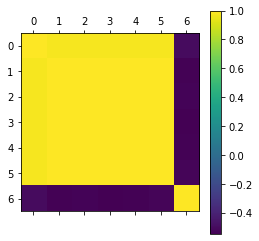

In [ ]:
corr_df = series_df - series_df.mean()
corr_df = corr_df / corr_df.std()
plt.matshow(corr_df.corr())
plt.colorbar()
plt.show()

In [ ]:
series_df = series_df.drop(columns=['Date', 'Open', 'High', 'Low', 'Adj Close'])
series_df.head()

,Close,Volume
2641,102.870003,256935300
2642,106.110001,253769400
2643,107.160004,210842100
2644,107.959999,144999900
2645,108.029999,131283600


In [ ]:
train_df[:10]

,Close,Volume
2641,102.870003,256935300
2642,106.110001,253769400
2643,107.160004,210842100
2644,107.959999,144999900
2645,108.029999,131283600
2646,109.660004,213025900
2647,109.650002,184426800
2648,109.680000,232337900
2649,106.660004,282693400
2650,107.290001,186709000


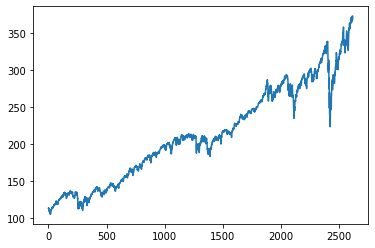

In [ ]:
window = 20
temp = [(np.array(series_df.iloc[i:i+window]), np.array(series_df.iloc[i+window+1, 0])) 
          for i in range(len(series_df) // window * window - window - 1)]
X, y = zip(*temp)
X, y = np.array(X), np.array(y)

plt.plot(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
train_size = int(0.7 * len(X))
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

In [ ]:
X_train_shape = X_train.shape
X_test_shape = X_test.shape
X_train = X_train.reshape((-1, X_train.shape[2]))
X_test = X_test.reshape((-1, X_test.shape[2]))

In [ ]:
X_train.shape

array([[1.02870003e+02, 2.56935300e+08],
       [1.06110001e+02, 2.53769400e+08],
       [1.07160004e+02, 2.10842100e+08],
       [1.07959999e+02, 1.44999900e+08],
       [1.08029999e+02, 1.31283600e+08],
       [1.09660004e+02, 2.13025900e+08],
       [1.09650002e+02, 1.84426800e+08],
       [1.09680000e+02, 2.32337900e+08],
       [1.06660004e+02, 2.82693400e+08],
       [1.07290001e+02, 1.86709000e+08]])

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled = X_train_scaled.reshape(X_train_shape)
X_test_scaled = X_test_scaled.reshape(X_test_shape)
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return backend.sqrt(backend.mean(backend.square(y_pred - y_true))) 

In [ ]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(40, activation='relu', return_sequences=True, input_shape=(window, 2), name='lstm1'))
model.add(tf.keras.layers.LSTM(20, activation='relu', name='lstm2'))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu, name='dense1'))

adam = tf.keras.optimizers.Adam()

model.compile(optimizer=adam, loss="mean_squared_error")

history = model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.125, shuffle=False)
model.summary()

Epoch 1/50
51/51 [==============================] - 5s 28ms/step - loss: 20636.6849 - val_loss: 1099678.5000
Epoch 2/50
51/51 [==============================] - 1s 20ms/step - loss: 19048.6168 - val_loss: 6821.8252
Epoch 3/50
51/51 [==============================] - 1s 20ms/step - loss: 32823.1162 - val_loss: 971.6658
Epoch 4/50
51/51 [==============================] - 1s 18ms/step - loss: 553.2931 - val_loss: 3768.9761
Epoch 5/50
51/51 [==============================] - 1s 17ms/step - loss: 1448.9818 - val_loss: 1192.9791
Epoch 6/50
51/51 [==============================] - 1s 18ms/step - loss: 1330.4065 - val_loss: 721.0605
Epoch 7/50
51/51 [==============================] - 1s 21ms/step - loss: 1626.8745 - val_loss: 563.3804
Epoch 8/50
51/51 [==============================] - 1s 21ms/step - loss: 1933.0964 - val_loss: 670.7515
Epoch 9/50
51/51 [==============================] - 1s 20ms/step - loss: 2314.9885 - val_loss: 948.5735
Epoch 10/50
51/51 [==============================] - 1s

<function matplotlib.pyplot.show>

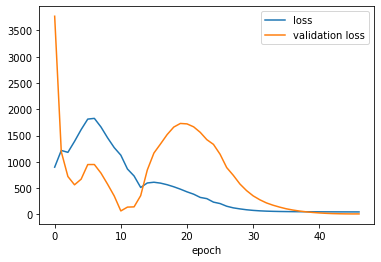

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss[3:], label='loss')
plt.plot(val_loss[3:], label='validation loss')
plt.xlabel('epoch')
plt.legend()
plt.show

In [ ]:
model.evaluate(X_test_scaled, y_test, return_dict=True)

25/25 [==============================] - 0s 7ms/step - loss: 293.8230


{'loss': 293.8229675292969}

(786, 1)


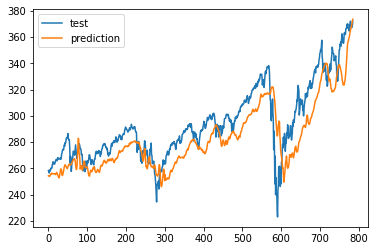

In [ ]:
y_pred = model.predict(X_test_scaled)
print(y_pred.shape)
l = len(y_pred)
plt.plot(y_test, label='test')
plt.plot(y_pred, label='prediction')
plt.legend()

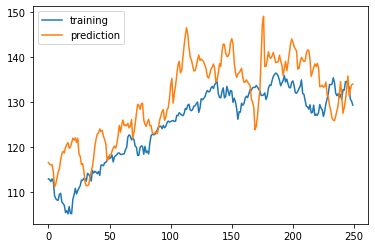

In [ ]:
y_pred = model.predict(X_train_scaled)
l = len(y_pred)
plt.plot(y_train[0:250], label='training')
plt.plot(y_pred[0:250], label='prediction')
plt.legend()